In [29]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import utils

# Preprocessing Data

In [5]:
train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

target_variable = "HeartDisease"

continuous_features = list(train._get_numeric_data().columns) + ["AgeCategory"]
categorical_features = list(set(train.columns) - set(continuous_features) - set([target_variable]))

In [6]:
def mean_of_age_category(row):
    if "older" in row:
        return 80
    else:
        return np.mean(list(map(int, row.split("-"))))


def data_preprocessing(data: pd.DataFrame, categorical_features: List[str], continuous_features: List[str], target_variable: str):

    df = data.copy()

    # protected variables
    sex = df["Sex"].values
    age = df["AgeCategory"].values
    race = df["Race"].values

    # target
    target = df[target_variable].values
    d = {"No":0, "Yes":1}
    target = np.array(list(map(lambda x: d[x], target)))

    df_processed = df[categorical_features + continuous_features].copy()
    df_processed["AgeCategory"] = df_processed["AgeCategory"].apply(mean_of_age_category)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_',
                                  dummy_na=False, columns=categorical_features, drop_first=True)

    return df_processed, df, target, sex, age, race


train_processed, train_original, train_target, train_sex, train_age, train_race = data_preprocessing(
    train, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

val_processed, val_original, val_target, val_sex, val_age, val_race = data_preprocessing(
    val, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

# Equalized odds with roc curves

### Model

In [31]:
scaler = ColumnTransformer(
    [('scaler', StandardScaler(), continuous_features)], remainder='passthrough')

whitebox_model = Pipeline(steps=[('scaler', scaler), ('clf', LogisticRegression(max_iter=10000))])

whitebox_model.fit(train_processed, train_target)
y_pred_whitebox = whitebox_model.predict(val_processed)
y_pred_proba_whitebox = whitebox_model.predict_proba(val_processed)

print(classification_report(val_target, y_pred_whitebox))
print(utils.classification_report(val_target, y_pred_whitebox, val_race))
print(confusion_matrix(val_target, y_pred_whitebox, normalize='true', labels=[1, 0]))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     43863
           1       0.55      0.11      0.19      4106

    accuracy                           0.92     47969
   macro avg       0.74      0.55      0.57     47969
weighted avg       0.89      0.92      0.89     47969

A                              TPR   FPR  
------------------------------------------
American Indian/Alaskan Native 0.11  0.02 
Asian                          0.12  0.00 
Black                          0.06  0.01 
Hispanic                       0.08  0.00 
Other                          0.13  0.01 
White                          0.12  0.01 
All                            0.11  0.01 
[[0.11203117 0.88796883]
 [0.00857215 0.99142785]]


In [10]:
def equalized_odds(preds, groups, test):
    df = pd.DataFrame(list(zip(preds, groups, test)), columns=['preds', 'groups', 'test'])
    targets = df['test'].unique()
    groups = df['groups'].unique()
    labels = []
    y = []
    
    for target in targets:
        temp_labels = []
        temp_y = []
        for group in groups:
            selection = df.loc[(df['test'] == target) & (df['groups'] == group)]
            corrects = selection.loc[selection['preds'] == target]
            score = round(len(corrects) / len(selection), 3)
            temp_labels.append(f'T: {target}, G: {group}')
            temp_y.append(score)
        labels.append(temp_labels)
        y.append(temp_y)
    

    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(8,6), sharey=True)
    
    x = np.arange(len(groups))  # the label locations
    x = np.array([i*2 for i in x])
    width = 0.8
    
    rects1 = ax.bar(x - width/2, y[0], width, label='No') #0
    rects2 = ax.bar(x + width/2, y[1], width, label='Yes') #1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Scores by group and target')
    ax.set_xticks(x, groups, rotation=10)
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    plt.tight_layout()
    plt.show()

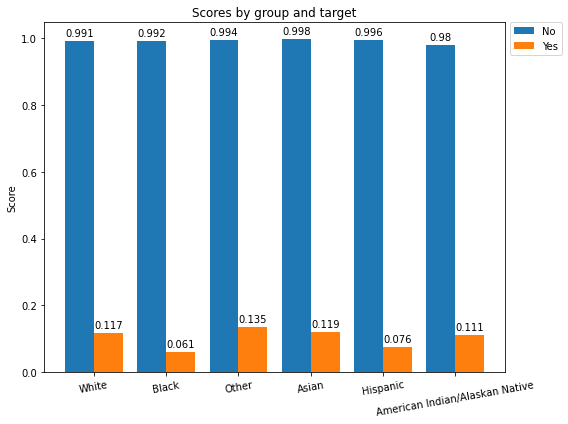

In [9]:
equalized_odds(y_pred_whitebox, val_race, val_target)

### Roc curve


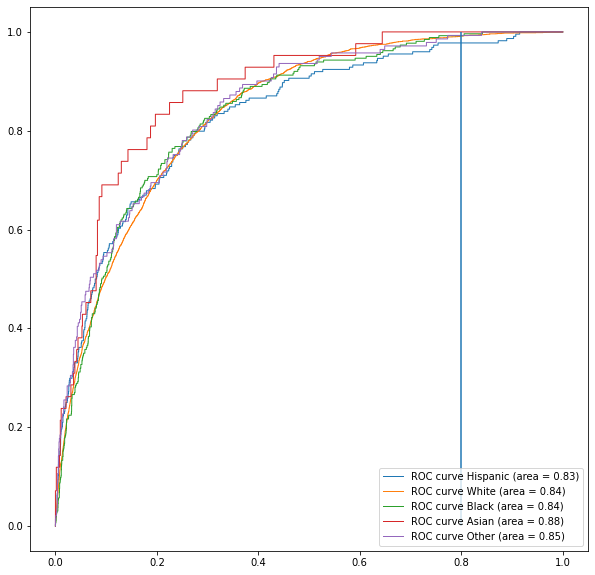

In [12]:
races = ["Hispanic", "White", "Black", "Asian", "Other"] #need to include last race

fix, ax = plt.subplots(figsize=(10,10))
parameters = {"fpr": [], "tpr": [], "threshold": []}

for race in races:
    y_score = y_pred_proba_whitebox[val_processed["Race_"+race]==1]
    fpr, tpr, threshold = roc_curve(val_target[val_processed["Race_"+race]==1], y_score[:, 1], drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(
        fpr,
        tpr,
        lw=1,
        label=f"ROC curve {race} (area = %0.2f)" % roc_auc)
    parameters["fpr"].append(fpr)
    parameters["tpr"].append(tpr)
    parameters["threshold"].append(threshold)
    
plt.vlines(0.8, 0, 1) #example of desired fpr
plt.legend()

In [32]:
def find_thresholds(parameters, i, fpr_goal=0.01):
    threshold = parameters["threshold"][i]
    fpr = parameters["fpr"][i]
    
    idx = np.argmin(abs(fpr_goal - parameters["fpr"][i]))
    threshold = parameters["threshold"][i][idx]
    
    return threshold

In [33]:
races = ["Hispanic", "White", "Black", "Asian", "Other"]


hispanic_threshold = find_thresholds(parameters, 0)
white_threshold = find_thresholds(parameters, 1)
black_threshold = find_thresholds(parameters, 2)
asian_threshold = find_thresholds(parameters, 3)
other_threshold = find_thresholds(parameters, 4)

print(hispanic_threshold, white_threshold, black_threshold, asian_threshold, other_threshold)

0.39045846738950235 0.48950543140256225 0.47014119565425105 0.3526215176899261 0.4297160009914232


In [40]:
# Re-calculate fairness metrics (equalized odds) with new thresholds
# this could be done with more races

y_pred_fair = list()
for race, proba in zip(val_original['Race'], y_pred_proba_whitebox[:,1]):
    if race == "White":
        y_pred_fair.append(1 if proba >= np.random.choice([hispanic_threshold, white_threshold], p=[0.5, 0.5]) else 0)
    elif race == "Black":
        y_pred_fair.append(1 if proba >= np.random.choice([hispanic_threshold, black_threshold], p=[0.5, 0.5]) else 0)
    elif race == "Asian":
        y_pred_fair.append(1 if proba >= np.random.choice([hispanic_threshold, asian_threshold], p=[0.5, 0.5]) else 0)
    elif race == "Other":
        y_pred_fair.append(1 if proba >= np.random.choice([hispanic_threshold, other_threshold], p=[0.5, 0.5]) else 0)   
    elif race == "Hispanic":
        y_pred_fair.append(1 if proba >= hispanic_threshold else 0)
    else: #American Indian/Alaskan Native (needs its own threshold)
        y_pred_fair.append(1 if proba >= np.random.choice([hispanic_threshold, other_threshold], p=[0.5, 0.5]) else 0) 
y_pred_fair = np.array(y_pred_fair)

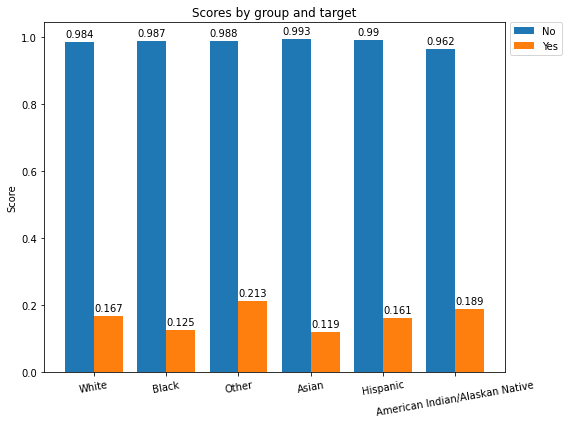

In [41]:
equalized_odds(y_pred_fair, val_race, val_target)

In [42]:
confusion_matrix(val_target, y_pred_fair, normalize='true', labels=[1, 0])

array([[0.16536775, 0.83463225],
       [0.01513804, 0.98486196]])

In [43]:
print(utils.classification_report(val_target, y_pred_fair, val_race))

A                              TPR   FPR  
------------------------------------------
American Indian/Alaskan Native 0.19  0.04 
Asian                          0.12  0.01 
Black                          0.13  0.01 
Hispanic                       0.16  0.01 
Other                          0.21  0.01 
White                          0.17  0.02 
All                            0.17  0.02 
